/Users/6706363/PycharmProjects/PPM_NextResource/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Feature matrix shape (model input): (47, 1202)
✅ Model loaded successfully.


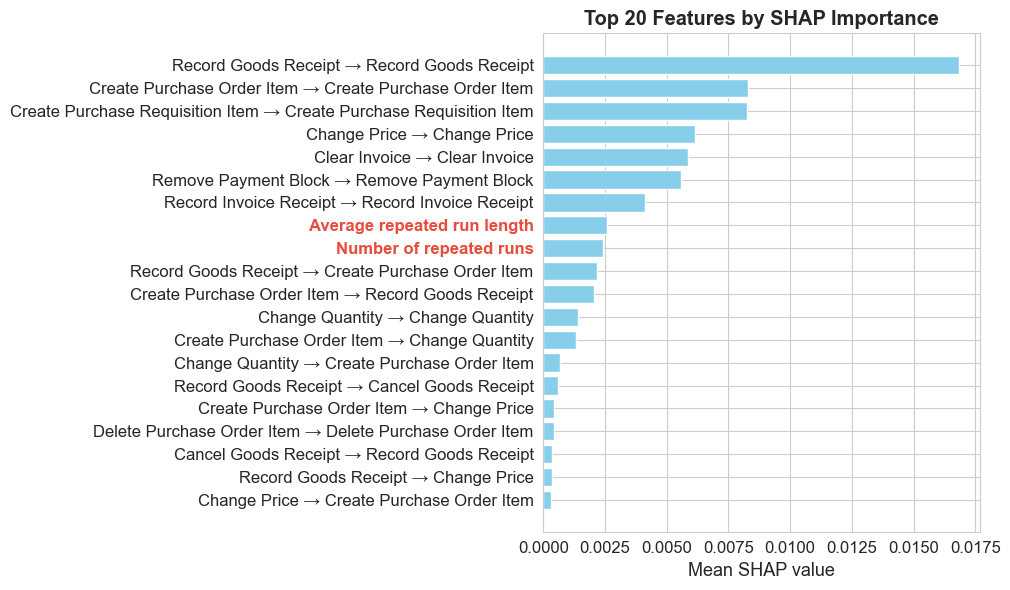

✅ Top 20 SHAP features plotted and saved (bold + colored labels applied).


/var/folders/6w/dtw1zzgj0xsfgl0vm5_4cynh0000gn/T/ipykernel_22753/492222264.py:250: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


✅ SHAP summary bar plot saved as PNG: figures/shap_summary_bar.png


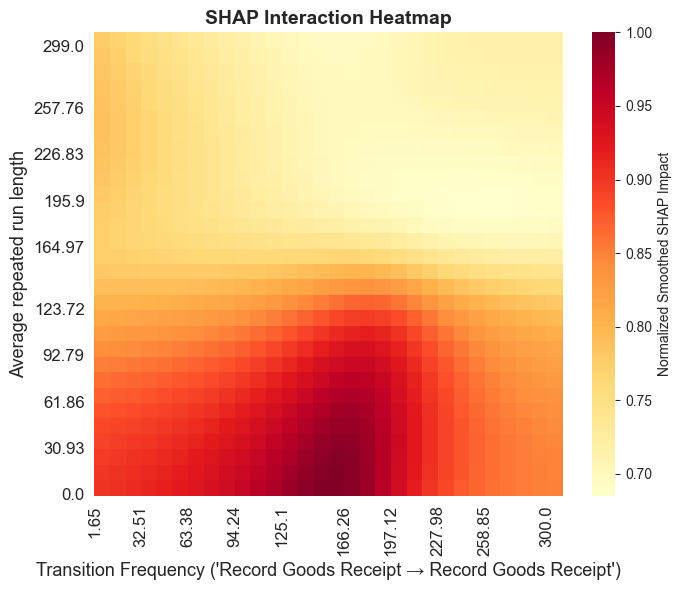

In [5]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import defaultdict
import torch.nn as nn

# --------------------------
# 1️⃣ Config paths
# --------------------------
ENCODER_PATH = os.path.abspath("Next Activity Resource Perspective/models/activity_label_encoder_seq300.pkl")
MODEL_PATH = os.path.abspath("Next Activity Resource Perspective/models/bpic2019_transformer_s2gr_seq300.pt")
DATA_PATH = os.path.abspath("Next Activity Resource Perspective/data/bpic2019_s2gr_test_seq300.csv")
FIGURE_DIR = "figures"
os.makedirs(FIGURE_DIR, exist_ok=True)

PREFIX_LENGTH = 300  # sequence length used in training
NUM_FEATURES = 1202  # matches checkpoint embedding.weight.shape[1]
NUM_CLASSES = 30     # matches checkpoint fc.weight.shape[0]
D_MODEL = 64
NUM_HEADS = 4
NUM_LAYERS = 1

# --------------------------
# 2️⃣ Load LabelEncoder safely
# --------------------------
with open(ENCODER_PATH, "rb") as f:
    label_encoder = pickle.load(f)

def safe_transform(encoder, series):
    return series.apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

# --------------------------
# Map specific transition indices to human-readable strings
# --------------------------
transition_dict = {
    465: "Record Goods Receipt → Record Goods Receipt",
    341: "Create Purchase Requisition Item → Create Purchase Requisition Item",
    310: "Create Purchase Order Item → Create Purchase Order Item",
    186: "Change Price → Change Price",
    279: "Clear Invoice → Clear Invoice",
    589: "Remove Payment Block → Remove Payment Block",
    496: "Record Invoice Receipt → Record Invoice Receipt",
    315: "Create Purchase Order Item → Record Goods Receipt",
    460: "Record Goods Receipt → Create Purchase Order Item",
    217: "Change Quantity → Change Quantity",
    307: "Create Purchase Order Item → Change Quantity",
    451: "Record Goods Receipt → Cancel Goods Receipt",
    220: "Change Quantity → Create Purchase Order Item",
    306: "Create Purchase Order Item → Change Price",
    372: "Delete Purchase Order Item → Delete Purchase Order Item",
    45:  "Cancel Goods Receipt → Record Goods Receipt",
    456: "Record Goods Receipt → Change Price",
    190: "Change Price → Create Purchase Order Item",
    195: "Change Price → Record Goods Receipt"
}

# --------------------------
# 3️⃣ Load test data
# --------------------------
X_test_raw = pd.read_csv(DATA_PATH)

activity_cols = [f"activity_{i+1}" for i in range(PREFIX_LENGTH)]
cols_to_transform = [c for c in activity_cols if c in X_test_raw.columns]

for col in cols_to_transform:
    X_test_raw[col] = safe_transform(label_encoder, X_test_raw[col])

if 'next_activity' in X_test_raw.columns:
    X_test_raw['next_activity'] = safe_transform(label_encoder, X_test_raw['next_activity'])

# --------------------------
# 4️⃣ Feature engineering
# --------------------------
def create_transition_and_repeat_features(sequences_df):
    feature_cols = [c for c in sequences_df.columns if c not in ['next_activity', 'org:resource']]
    unique_activities = sorted(set(sequences_df[feature_cols].values.flatten()) - {None})
    all_possible_transitions = [(a, b) for a in unique_activities for b in unique_activities]

    transition_counts = []
    repeat_pattern_features = []

    for _, row in sequences_df.iterrows():
        transitions = defaultdict(int)
        activities = row[feature_cols].dropna().tolist()
        for i in range(len(activities)-1):
            transitions[(activities[i], activities[i+1])] += 1
        row_counts = [transitions.get((a,b),0) for (a,b) in all_possible_transitions]
        transition_counts.append(row_counts)

        current_run = 1
        run_lengths = []
        for i in range(1, len(activities)):
            if activities[i] == activities[i-1]:
                current_run +=1
            else:
                run_lengths.append(current_run)
                current_run = 1
        run_lengths.append(current_run)
        repeat_pattern_features.append([np.mean(run_lengths), len(run_lengths)])

    transitions_df = pd.DataFrame(transition_counts)
    repeat_df = pd.DataFrame(repeat_pattern_features, columns=["avg_run_length", "num_runs"])
    return pd.concat([sequences_df.reset_index(drop=True), transitions_df, repeat_df], axis=1)

X_test_fe = create_transition_and_repeat_features(X_test_raw)
X_features = X_test_fe.drop(columns=[c for c in ['next_activity', 'org:resource'] if c in X_test_fe.columns])

# --------------------------
# 5️⃣ Ensure feature matrix matches model input
# --------------------------
if X_features.shape[1] > NUM_FEATURES:
    X_features_model = X_features.iloc[:, :NUM_FEATURES]
elif X_features.shape[1] < NUM_FEATURES:
    missing = NUM_FEATURES - X_features.shape[1]
    X_features_model = pd.concat(
        [X_features, pd.DataFrame(np.zeros((X_features.shape[0], missing)))],
        axis=1
    )
else:
    X_features_model = X_features

print(f"✅ Feature matrix shape (model input): {X_features_model.shape}")

# --------------------------
# 6️⃣ Define Transformer
# --------------------------
class ActivityTransformer(nn.Module):
    def __init__(self, num_features=NUM_FEATURES, num_classes=NUM_CLASSES,
                 d_model=D_MODEL, num_heads=NUM_HEADS, num_layers=NUM_LAYERS, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

model = ActivityTransformer()
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()
print("✅ Model loaded successfully.")

# --------------------------
# 7️⃣ SHAP model wrapper
# --------------------------
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.numpy()

# --------------------------
# 8️⃣ SHAP computation
# --------------------------
n_background = min(10, len(X_features_model))
background = X_features_model.sample(n_background, random_state=42).values

n_sample = min(50, len(X_features_model))
X_sample = X_features_model.sample(n_sample, random_state=42).values

explainer = shap.Explainer(model_predict, background, algorithm="auto")
shap_values = explainer(X_sample)

# --------------------------
# 9️⃣ Top 20 features by mean absolute SHAP
# --------------------------
shap_mean = np.abs(shap_values.values).mean(axis=(0,2))

feature_importance = pd.DataFrame({
    "feature_id": X_features_model.columns,
    "mean_abs_shap": shap_mean
})

def decode_feature(fid, label_encoder=label_encoder, transition_dict=transition_dict):
    fid_str = str(fid)
    if fid_str.isdigit():
        idx = int(fid_str)
        if idx in transition_dict:
            return transition_dict[idx]
        else:
            try:
                return label_encoder.inverse_transform([idx])[0]
            except:
                return fid_str
    elif fid_str.startswith("activity_"):
        try:
            col_idx = int(fid_str.split("_")[1])
            return f"Activity column {col_idx}"
        except:
            return fid_str
    elif fid_str == "avg_run_length":
        return "Average repeated run length"
    elif fid_str == "num_runs":
        return "Number of repeated runs"
    else:
        return fid_str

feature_importance["decoded"] = feature_importance["feature_id"].apply(decode_feature)
top_10 = feature_importance.sort_values(by="mean_abs_shap", ascending=False).head(20)


# --------------------------
# 🔟 Plot top 20 features
# --------------------------
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10["decoded"][::-1], top_10["mean_abs_shap"][::-1], color="skyblue")

plt.xlabel("Mean SHAP value", fontsize=13)
plt.title("Top 20 Features by SHAP Importance", fontweight="bold", fontsize="x-large")

ax = plt.gca()

ax.tick_params(axis='both', labelsize=12)


# --- Set y-tick labels ---
y_labels = [label.get_text() for label in ax.get_yticklabels()]

# Apply bold font for specific labels
for label in ax.get_yticklabels():
    text = label.get_text().strip()
    if text == "Average repeated run length":
        label.set_fontweight("bold")
        label.set_color("#E74C3C")  # red
    elif text == "Number of repeated runs":
        label.set_fontweight("bold")
        label.set_color("#E74C3C")  # orange

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "top_20_shap_features_decoded.png"), dpi=300)
plt.show()

print("✅ Top 20 SHAP features plotted and saved (bold + colored labels applied).")

# --------------------------
# 🔟 SHAP built-in bar summary plot
# --------------------------
feature_names = feature_importance["decoded"].values
plt.figure(figsize=(10,6))
shap.summary_plot(
    shap_values,
    X_features_model,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
bar_png_path = os.path.join(FIGURE_DIR, "shap_summary_bar.png")
plt.savefig(bar_png_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ SHAP summary bar plot saved as PNG: {bar_png_path}")
###########################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# ------------------------------------------------
# 1️⃣ Prep SHAP + features data
# ------------------------------------------------
focus_feature = 'avg_run_length'
transition_feature = '465'

if shap_values.values.ndim == 3:
    shap_focus = np.abs(shap_values.values[:, X_features_model.columns.get_loc(focus_feature), :]).mean(axis=1)
    shap_transition = np.abs(shap_values.values[:, X_features_model.columns.get_loc(transition_feature), :]).mean(axis=1)
else:
    shap_focus = np.abs(shap_values.values[:, X_features_model.columns.get_loc(focus_feature)])
    shap_transition = np.abs(shap_values.values[:, X_features_model.columns.get_loc(transition_feature)])

focus_vals = X_features_model[focus_feature].values
transition_vals = X_features_model[transition_feature].values
shap_vals = (shap_focus + shap_transition)/2

# ------------------------------------------------
# 2️⃣ Construct 2D domain grid for evaluation
# ------------------------------------------------
# grid resolution: adjust if needed
grid_size = 30  

x_min, x_max = np.min(focus_vals), np.max(focus_vals)
y_min, y_max = np.min(transition_vals), np.max(transition_vals)

x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)

Xg, Yg = np.meshgrid(x_grid, y_grid)

# ------------------------------------------------
# 3️⃣ Fit KDEs
# ------------------------------------------------
# KDE for data density
xy_samples = np.vstack([focus_vals, transition_vals])
kde_density = gaussian_kde(xy_samples)

# KDE for SHAP-weighted density
xy_shap_samples = np.vstack([focus_vals, transition_vals])
kde_shap = gaussian_kde(xy_shap_samples, weights=shap_vals)

# ------------------------------------------------
# 4️⃣ Evaluate KDEs on the grid
# ------------------------------------------------
pos = np.vstack([Xg.ravel(), Yg.ravel()])

density_grid = kde_density(pos).reshape(grid_size, grid_size)
shap_grid = kde_shap(pos).reshape(grid_size, grid_size)

# ------------------------------------------------
# 5️⃣ Compute smoothed SHAP surface
# ------------------------------------------------
# Avoid division by zero (in extremely low-density regions)
shap_smooth = np.divide(
    shap_grid,
    density_grid,
    out=np.zeros_like(shap_grid),
    where=density_grid > 1e-12
)

# Normalize for visualization
shap_smooth_norm = shap_smooth / np.max(shap_smooth)

# ------------------------------------------------
# 6️⃣ Plot heatmap
# ------------------------------------------------
plt.figure(figsize=(7, 6))

sns.heatmap(
    shap_smooth_norm,
    cmap="YlOrRd",
    cbar_kws={'label': 'Normalized Smoothed SHAP Impact'}
)

# Fix axis ticks
num_ticks = 10  # choose how many labels you want

# Fix axis orientation
plt.gca().invert_yaxis()


x_idx = np.linspace(0, len(x_grid)-1, num_ticks).astype(int)
y_idx = np.linspace(0, len(y_grid)-1, num_ticks).astype(int)

plt.xticks(x_idx, np.round(x_grid[x_idx], 2), fontsize=12)
plt.yticks(y_idx, np.round(y_grid[y_idx], 2), fontsize=12)

plt.xlabel("Transition Frequency ('Record Goods Receipt → Record Goods Receipt')", fontsize=13)
plt.ylabel("Average repeated run length", fontsize=13)
plt.title("SHAP Interaction Heatmap", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("shap_heatmap.png", dpi=300, bbox_inches='tight')  # <- saves figure
plt.show()